# Advance House Price Prediction

In this notebook we are going to predict the price of the houses which depends on many factors.
The following steps has been carriedout in this dataset: 
1. Data Cleaning
2. Exploratory Data Analysis
3. Feature Engineering
4. Selection of Different Linear Regression models
5. Hyper parameter tuning

Let's start exploring the dataset 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec 
from scipy import stats
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.simplefilter(action='ignore')
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import math
import sklearn.model_selection as ms
import sklearn.metrics as sklm

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
df = train

In [6]:
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df.drop('Id', axis = 1, inplace = True)
test.drop('Id', axis = 1, inplace = True)

The feture Id column does not convey any information, so we can delete it

In [9]:
train = df

In [10]:
train.shape[0]

1460

In [11]:
print(f"Number of rows and number of columns in the train dataset are {train.shape[0]} and {train.shape[1]}")
print(f"Number of rows and number of columns in the test dataset are {test.shape[0]} and {test.shape[1]}")

Number of rows and number of columns in the train dataset are 1460 and 80
Number of rows and number of columns in the test dataset are 1459 and 79


There is 1 column less in the test dataset because we need to predict the price of the houses for the test dataset

## SalePrice Feature Analysis

Let's Explore the target feature i.e SalesPrice distribution and outliers.

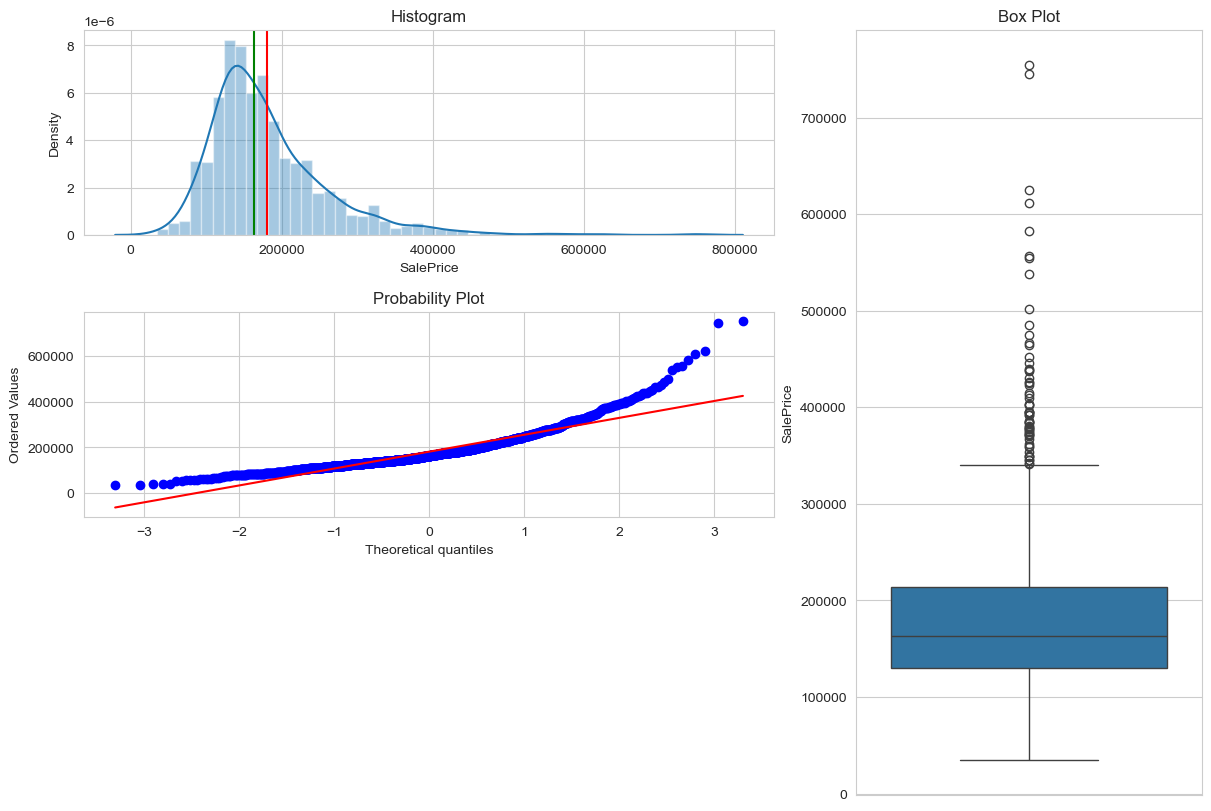

In [15]:
def three_chart_plot(df, feature):
    fig = plt.figure(constrained_layout = True, figsize = (12, 8))
    grid = gridspec.GridSpec(ncols = 3, nrows = 3, figure = fig)
    
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    
    sns.distplot(df.loc[:, feature], norm_hist = True, ax = ax1)
    plt.axvline(x = df[feature].mean(), c = 'red')
    plt.axvline(x = df[feature].median(), c = 'green')
    
    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('QQ_plot')
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    sns.boxplot(df.loc[:,feature], orient = 'v', ax = ax3 )
    
three_chart_plot(df, 'SalePrice')

**Red line in histogram indicates the mean of the SalePrice and the Green line indicates the median**

From the above plots, we can observe that the Sales Price is not normally distributed. From the boxplot we can observe that the dataset have a number of outliers.

For the probability plot, the red line represents those points which would have been plotted for y-axis points **if those were normally distributed**. But the blue points represents the actual scenario. We can see that there is a lot of deviation on the both the ends i.e on the top right and bottom left.

In [18]:
from scipy.stats import skew
print("Skewness of the SalesPrice is", df['SalePrice'].skew())

Skewness of the SalesPrice is 1.8828757597682129


Skewness refers to the amount of asymmetry in the given feature or in other words amount of distortions from the normal distribution. 

Here we can observe that the value of skewness is quite high which means that there is a large amount of asymmetry. 

The peak of the histogram represents the mode i.e the price for which maximum number of houses were sold.

What kind of skewness is present in the given case?

As the mean of the feature is greater than the median which is greater than the mode and the line is flat towards the right in the histogram, the given feature is **Positively Skewed**. Most of the houses were sold less than the average price.


## 1. Data cleaning 

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [22]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In the given dataset there are many null values present in the different feature columns. Therefore these should be handled properly  

In [24]:
train[['PoolQC']].isnull().sum()

PoolQC    1453
dtype: int64

In [25]:
def null_table(data):
    """
    A function which returns the number and percentage of null values present in the given dataset.
    """
    indices = data.isnull().sum().index
    values = data.isnull().sum().values
    percentages = []
    for ind in indices:
        percentages.append((data[ind].isnull().sum() / data[ind].shape[0]) * 100)
    d = {'Columns' : indices, 'Count of Null Values' : values, 'Approximate Percentage of Null Values' : percentages}
    # data = dict(zip(indices, percentages))
    null_frame = pd.DataFrame(data = d)
    return null_frame

In [26]:
ind=train.isnull().sum().index
ind

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [27]:
val=train.isnull().sum().values
num_non_zero = np.count_nonzero(val)
num_non_zero

19

There are 19 features have null values in the training data 

In [29]:
null_frame_train = null_table(df)
null_frame_train.sort_values(by = 'Approximate Percentage of Null Values').tail(20)

,Columns,Count of Null Values,Approximate Percentage of Null Values
21,RoofMatl,0,0.000000
41,Electrical,1,0.068493
25,MasVnrArea,8,0.547945
32,BsmtFinType1,37,2.534247
30,BsmtCond,37,2.534247
29,BsmtQual,37,2.534247
31,BsmtExposure,38,2.602740
34,BsmtFinType2,38,2.602740
58,GarageYrBlt,81,5.547945
62,GarageQual,81,5.547945


In [30]:
val=test.isnull().sum().values
num_non_zero = np.count_nonzero(val)
num_non_zero

33

There are 33 features have null values in the test data 

In [32]:
null_frame_test = null_table(test)
null_frame_test.sort_values(by = 'Approximate Percentage of Null Values').tail(34)

,Columns,Count of Null Values,Approximate Percentage of Null Values
16,OverallQual,0,0.000000
60,GarageCars,1,0.068540
61,GarageArea,1,0.068540
52,KitchenQual,1,0.068540
22,Exterior1st,1,0.068540
77,SaleType,1,0.068540
23,Exterior2nd,1,0.068540
37,TotalBsmtSF,1,0.068540
36,BsmtUnfSF,1,0.068540
33,BsmtFinSF1,1,0.068540


We must observe here that **NA has a different meaning**. Here we can not impute or remove those rows having NA. For example if one of the values for Alley is NA, it means that home has no Alley or if the value of GarageType is NA it means that particular home has no Garage. That's why we need to take into account these values as it can affect the final prices of the house.

Let's combine both the train and test dataset and analyze the null values

In [35]:
na = train.shape[0]
nb = test.shape[0]
y_train = train['SalePrice'].to_frame()
# Combine train and test sets
total = pd.concat((train, test), sort = False).reset_index(drop = True)
# Drop the target "SalePrice" and Id columns
total.drop(['SalePrice'], axis = 1, inplace = True)
print(f"Total size is {total.shape}")

Total size is (2919, 79)


In [36]:
total.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
2918,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [37]:
y_train.tail()

,SalePrice
1455,175000
1456,210000
1457,266500
1458,142125
1459,147500


In [38]:
null_frame_train = null_table(total)
null_frame_train.sort_values(by = 'Approximate Percentage of Null Values').tail(20)

,Columns,Count of Null Values,Approximate Percentage of Null Values
47,BsmtHalfBath,2,0.068517
1,MSZoning,4,0.137033
25,MasVnrArea,23,0.787941
32,BsmtFinType1,79,2.706406
34,BsmtFinType2,80,2.740665
29,BsmtQual,81,2.774923
31,BsmtExposure,82,2.809181
30,BsmtCond,82,2.809181
57,GarageType,157,5.378554
63,GarageCond,159,5.447071


In [39]:
val=total.isnull().sum().values
num_non_zero = np.count_nonzero(val)
num_non_zero

34

There are 34 features having null values. they need to be addressed before deloping a machine learning model

There are 7 columns having more percent null values. We will deal with these values later.

## 2. EDA
Numerical and Categorical Variables

### Exploring Numerical Variables

In [44]:
category_var = df.select_dtypes(include = 'object')
num_var = df.select_dtypes(exclude = 'object')

print("Number of categorical features are: ", category_var.shape[1])
print("Number of numerical features are: ", num_var.shape[1])

Number of categorical features are:  43
Number of numerical features are:  37


Before moving forward let's see the correlation of the numerical features with the target variable

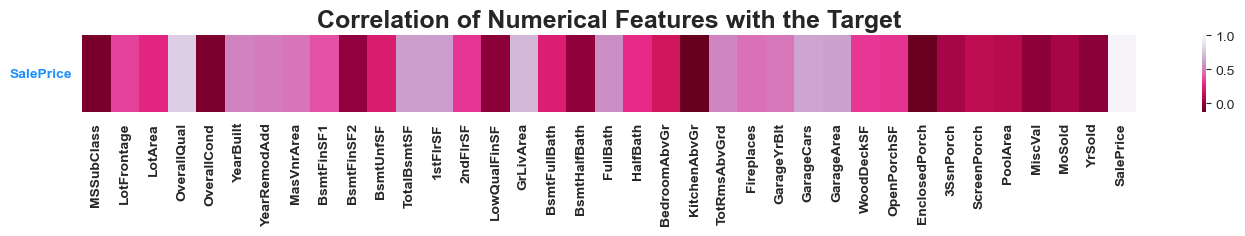

In [46]:
num = df.select_dtypes(exclude = 'object')
corr_num = num.corr()

f, ax = plt.subplots(figsize = (17, 1))

sns.heatmap(corr_num.sort_values(by = ['SalePrice'], ascending = False).head(1), cmap='PuRd_r')

plt.title('Correlation of Numerical Features with the Target', weight = 'bold', fontsize = 18)
plt.xticks(weight='bold')
plt.yticks(weight='bold', color='dodgerblue', rotation=0)

plt.show()

In [47]:
correlation = num.corr()['SalePrice'].sort_values(ascending = False).to_frame().head(30)

cmap = sns.light_palette("cyan", as_cmap = True)

s = correlation.style.background_gradient(cmap = cmap)

s

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


From the above table, we can conclude that better the overall quality of the house, more will be the price of the house which is also true in real life. Same is true for 
the living area i.e as the area increases, more will be the Sale Price.

Let's plot a graph to examine the relationship between GrLivArea and the SalePrice

#### GrLivArea

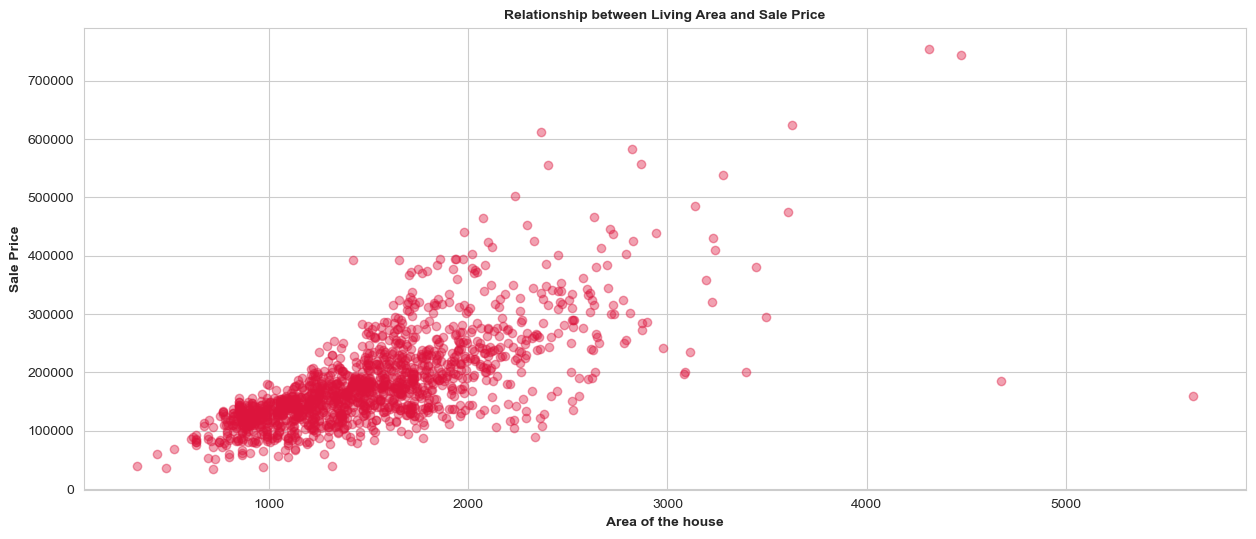

In [50]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'GrLivArea', y = 'SalePrice', data = df, color='crimson', alpha=0.4)
plt.title('Relationship between Living Area and Sale Price', weight = 'bold', fontsize = 10)
plt.xlabel('Area of the house', weight = 'bold')
plt.ylabel('Sale Price', weight = 'bold')
plt.show()

We can observe that there is almost **a linear relationship between Living Area and the Sale Price**. If the area is huge then price should also have also been high but the two rightmost points suggest something else. **These two points are outliers**. We will drop both of them below.

In [52]:
train = train[train['GrLivArea'] < 4500]
previous_train = df
df = train

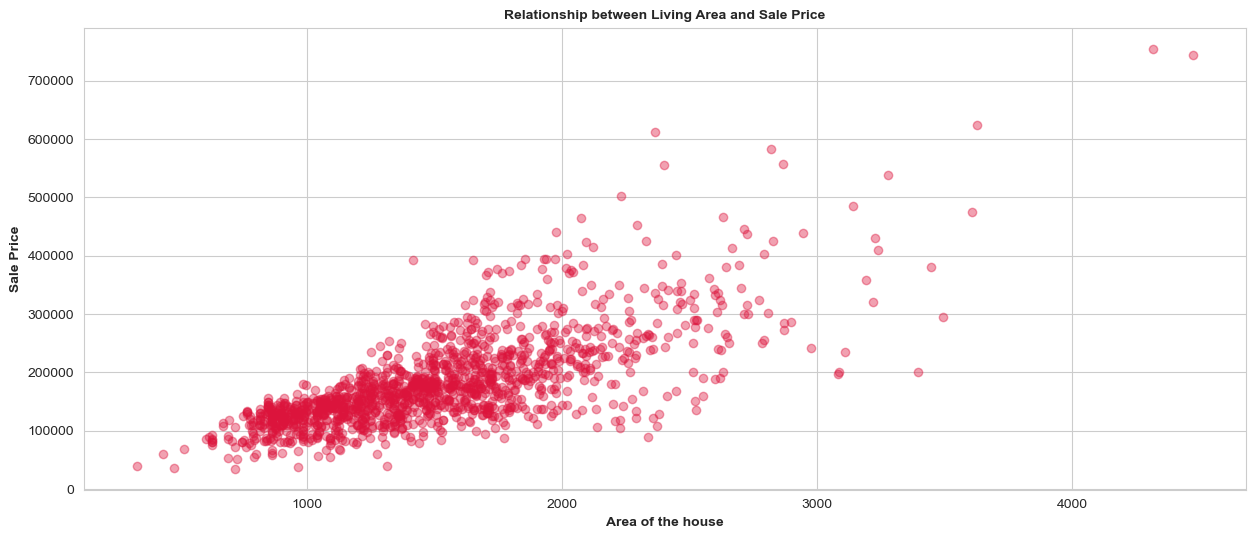

In [53]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'GrLivArea', y = 'SalePrice', data = df, color='crimson', alpha=0.4)
plt.title('Relationship between Living Area and Sale Price', weight = 'bold', fontsize = 10)
plt.xlabel('Area of the house', weight = 'bold')
plt.ylabel('Sale Price', weight = 'bold')
plt.show()

We can observe that those two values have been successfully dropped.

#### Garage Area

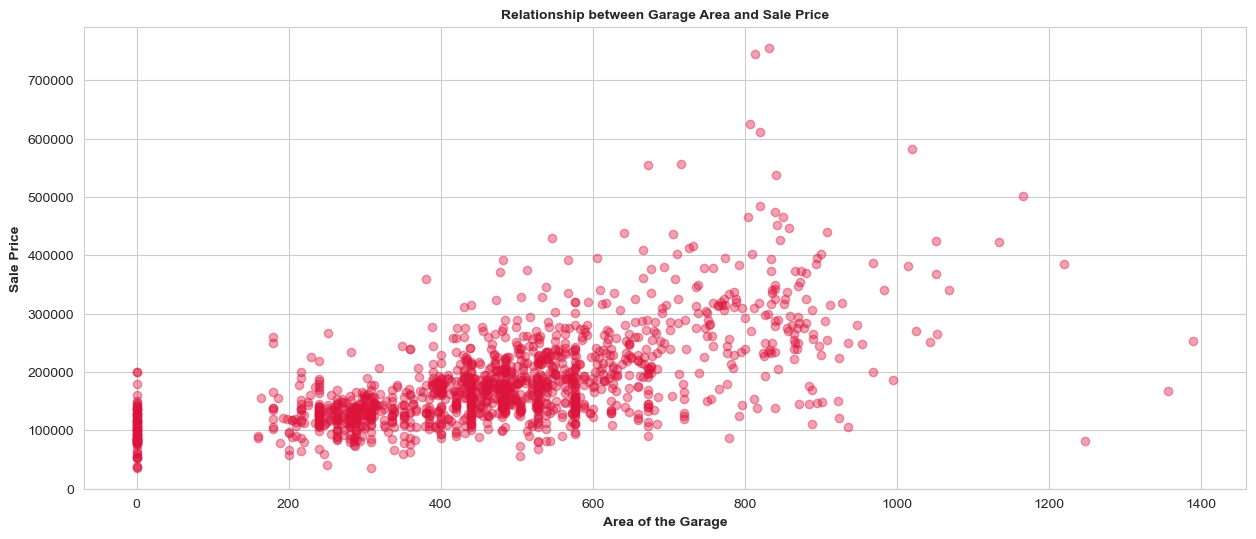

In [56]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'GarageArea', y = 'SalePrice', data = df, color='crimson', alpha=0.4)
plt.title('Relationship between Garage Area and Sale Price', weight = 'bold', fontsize = 10)
plt.xlabel('Area of the Garage', weight = 'bold')
plt.ylabel('Sale Price', weight = 'bold')
plt.show()

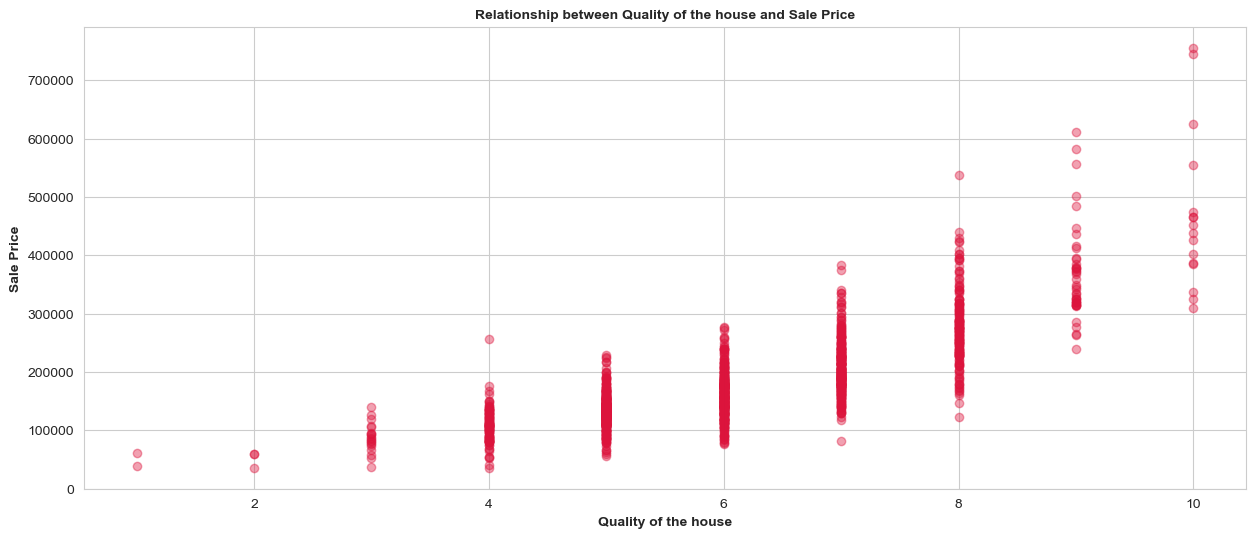

In [57]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'OverallQual', y = 'SalePrice', data = df, color='crimson', alpha=0.4)
plt.title('Relationship between Quality of the house and Sale Price', weight = 'bold', fontsize = 10)
plt.xlabel('Quality of the house', weight = 'bold')
plt.ylabel('Sale Price', weight = 'bold')
plt.show()

There is a linear relation between the quality of the house and Sale price

#### Total Basement Area

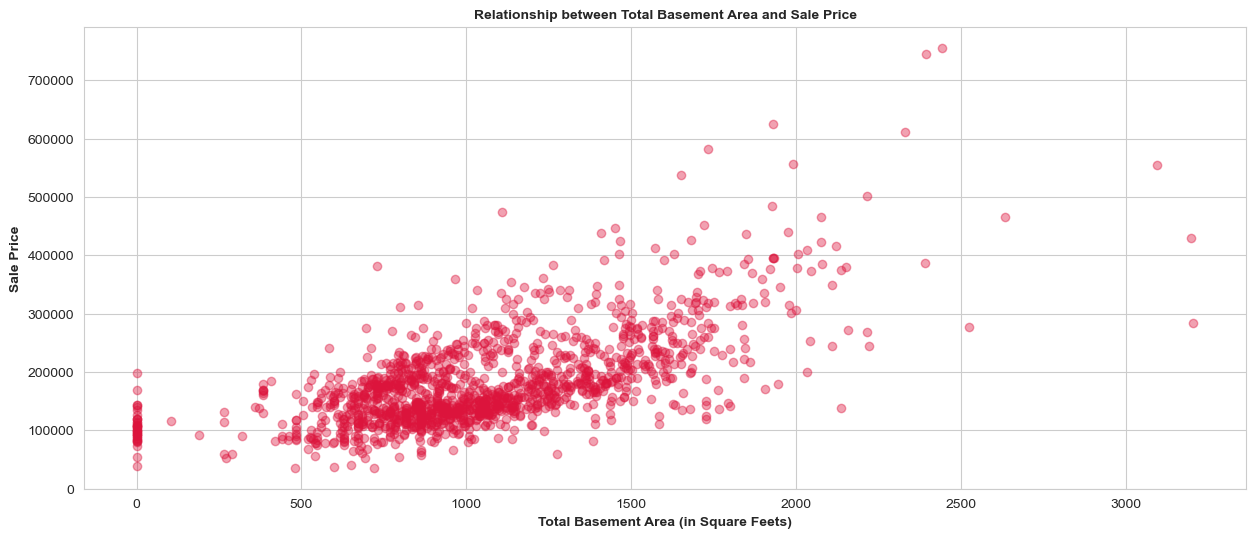

In [60]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = 'TotalBsmtSF', y = 'SalePrice', data = df, color = 'crimson', alpha = 0.4)
plt.title('Relationship between Total Basement Area and Sale Price', weight = 'bold', fontsize = 10)
plt.xlabel('Total Basement Area (in Square Feets)', weight = 'bold')
plt.ylabel('Sale Price', weight = 'bold')
plt.show()

#### 1st Floor Area

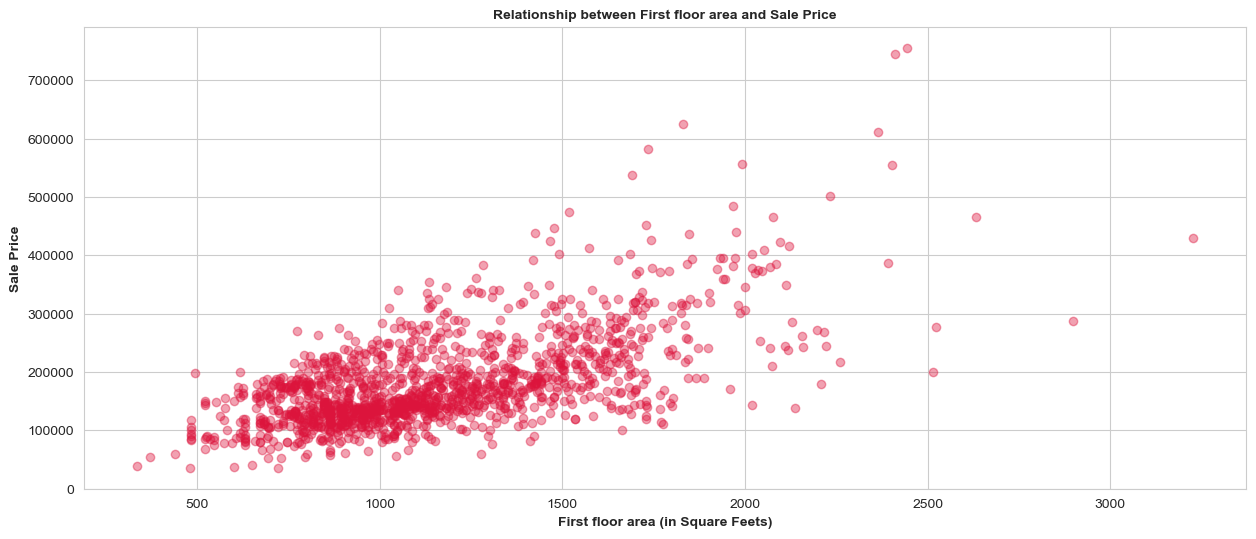

In [62]:
plt.figure(figsize = ((15, 6)))
plt.scatter(x = '1stFlrSF', y = 'SalePrice', data = df, color = 'crimson', alpha = 0.4)
plt.title('Relationship between First floor area and Sale Price', weight = 'bold', fontsize = 10)
plt.xlabel('First floor area (in Square Feets)', weight = 'bold')
plt.ylabel('Sale Price', weight = 'bold')
plt.show()

Before we move forward we need to understand the assumptions of linear regression:
* Linearity
* Homoscedasticity
* No or little Multicollinearity
* Independence of Error

Since we fit a linear model, we assume that the relationship is linear, and the errors, or residuals, are pure random fluctuations around the true line. We expect that the variability in the dependent variable doesn't increase as the value of the independent increases, which is the assumptions of equal variance, also known as Homoscedasticity. We also assume that the observations are independent of one another(No Multicollinearity), and a correlation between sequential observations or auto-correlation is not there.

Now, these assumptions are prone to happen altogether. In other words, if we see one of these assumptions in the dataset, it's more likely that we may come across with others mentioned above. Therefore, we can find and fix various assumptions with a few unique techniques.

In order to discover the linearity let's plot scatter plots for GrLivArea and MasVnrArea

<Axes: xlabel='MasVnrArea', ylabel='SalePrice'>

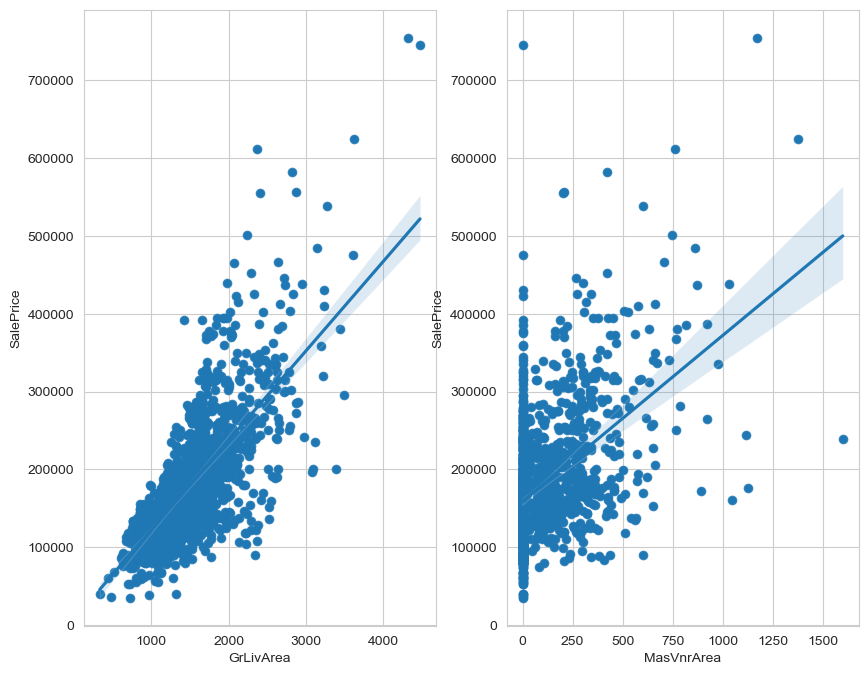

In [64]:
## Scatter plotting for SalePrice and GrLivArea.
fig, (ax1, ax2) = plt.subplots(figsize = (10, 8), ncols = 2,sharey = False)
 
sns.scatterplot(x = df['GrLivArea'], y = df['SalePrice'],  ax = ax1)
## Putting a regression line. 
sns.regplot(x = df['GrLivArea'], y = df['SalePrice'], ax = ax1)

sns.scatterplot(x = df['MasVnrArea'],y = df['SalePrice'], ax = ax2)
## regression line for MasVnrArea and SalePrice. 
sns.regplot(x = df['MasVnrArea'], y = df['SalePrice'], ax=ax2)

We can observe that the relationship between Sales Price and GrLivArea is much more linear than the relationship between Sales Price and MasVnrArea.

Let's look at the residual plot for independent variable GrLivArea and our target variable SalePrice. 

A residual value is a measure of how much a regression line vertically misses a data point. Regression lines are the best fit of a set of data. You can think of the lines as averages; a few data points will fit the line and others will miss. A residual plot has the Residual Values on the vertical axis; the horizontal axis displays the independent variable.

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

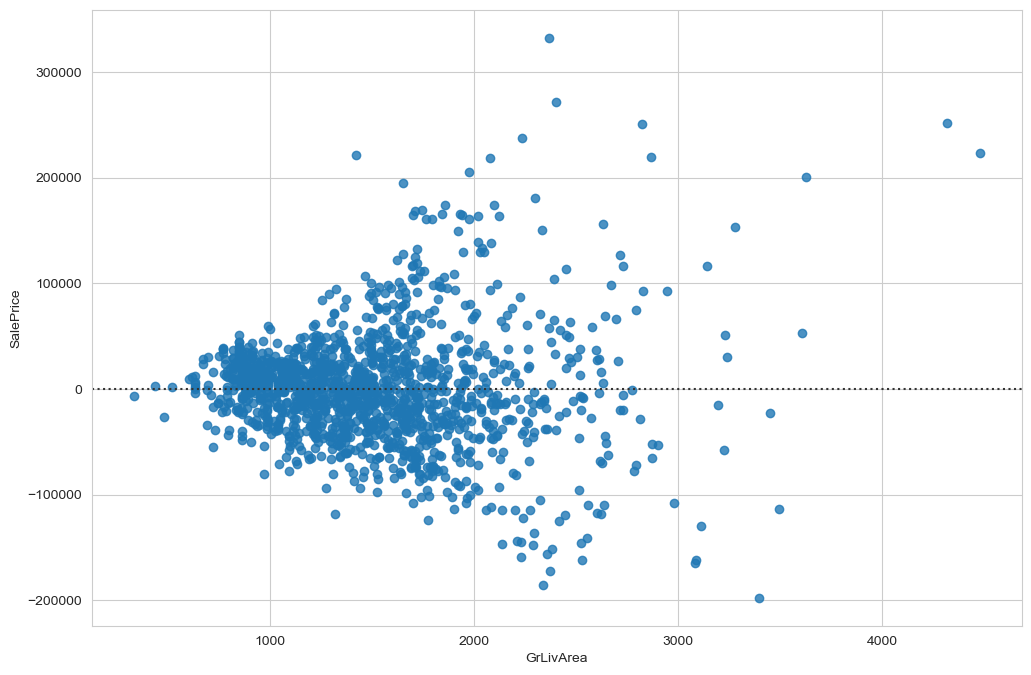

In [66]:
plt.subplots(figsize = (12,8))
sns.residplot(x=df['GrLivArea'], y=df['SalePrice'], data=df)

In [67]:
df.shape

(1458, 80)

Ideally, if the assumptions are met, the residuals will be randomly scattered around the centerline of zero with no apparent pattern. The residual will look like an unstructured cloud of points centered around zero. However, our residual plot is anything but an unstructured cloud of points. Even though it seems like there is a linear relationship between the response variable and predictor variable, the residual plot looks more like a funnel. 

The error plot shows that as GrLivArea value increases, the variance also increases, which is the characteristics known as Heteroscedasticity. The linear regression analysis requires the dependent variable to be multivariate normally distributed. A histogram, box plot, or a Q-Q-Plot can check if the target variable is normally distributed. 

Let's plot the three graphs again for the target feature.

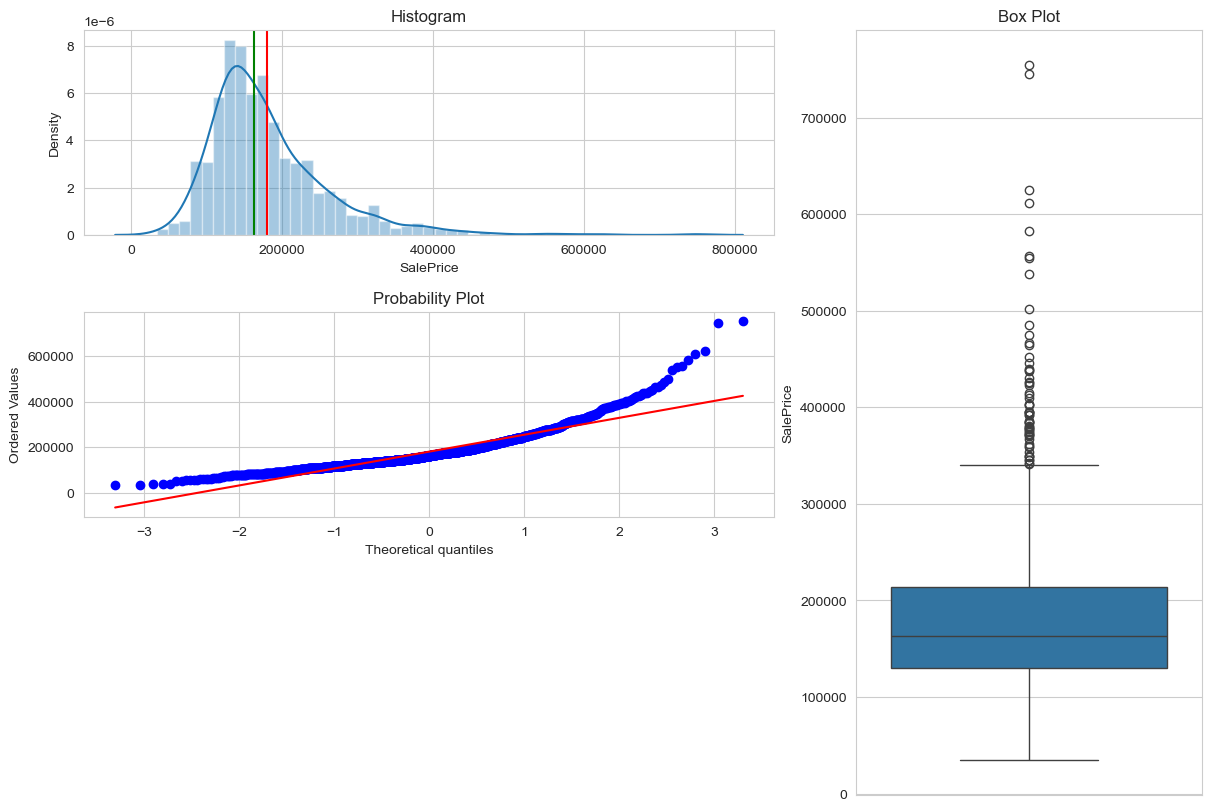

In [69]:
three_chart_plot(df, 'SalePrice')

Now let's make sure that the target variable follows a normal distribution. In order to make a feature follow normal distribution, we will perform log transformation.

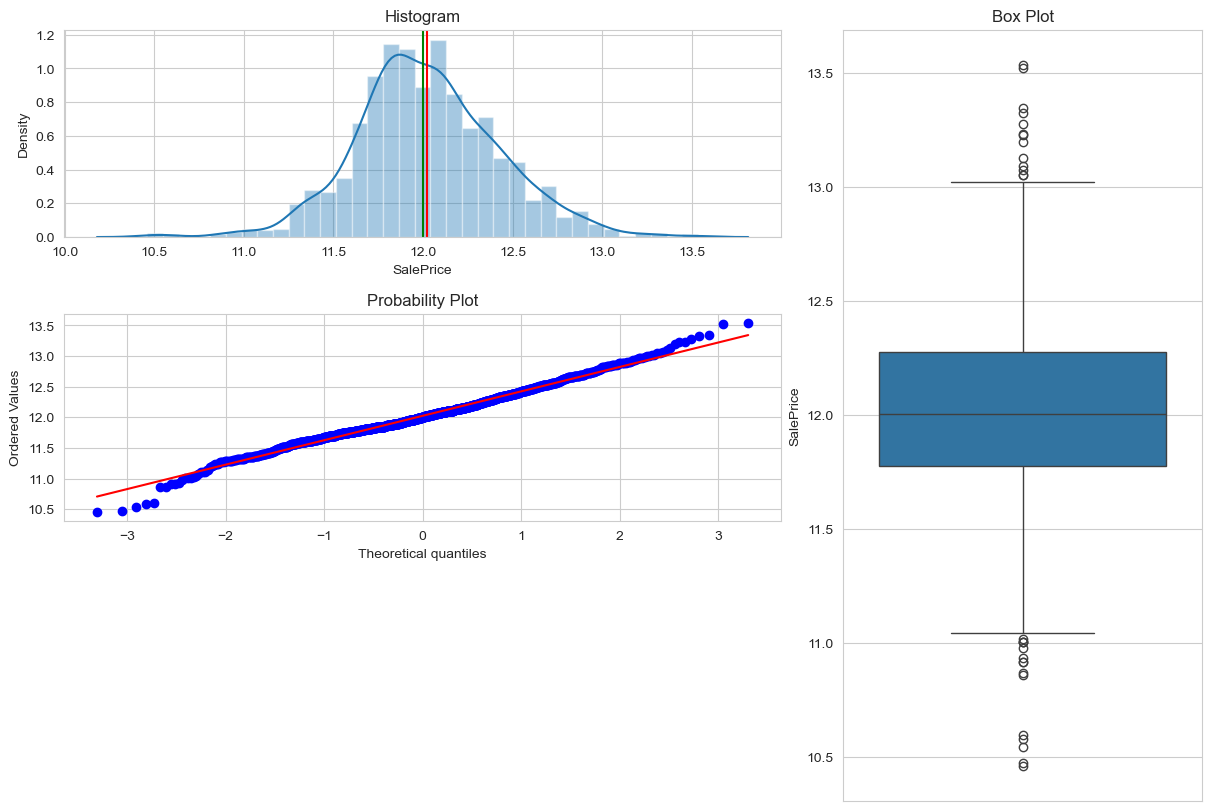

In [71]:
train["SalePrice"] = np.log1p(train["SalePrice"])
df = train
three_chart_plot(df, 'SalePrice')

We can observe that the SalesPrice feature now follows a normal distibution as the Histogram resembles bell-shape and the QQ-plot also overlaps with the red line. Let's again plot the scatter plot for GrLivArea and SalePrice to see whether Heteroscedasticity was removed.

In [73]:
previous_train=pd.read_csv('train.csv')

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

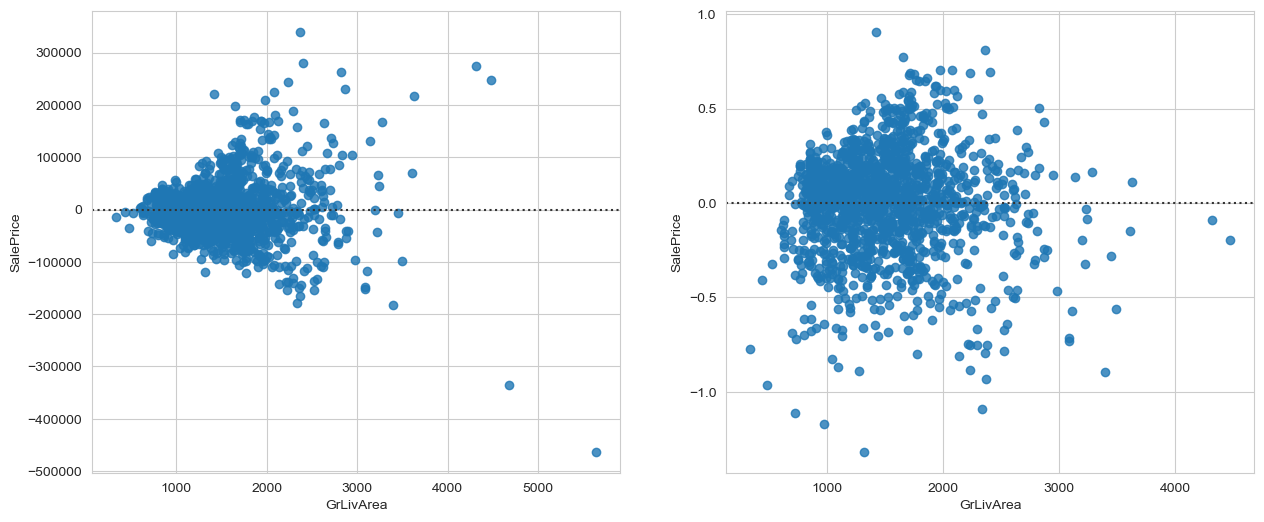

In [74]:
fig, (ax1, ax2) = plt.subplots(figsize = (15, 6),
                              ncols = 2,
                              sharey = False,
                              sharex = False)

sns.residplot(x=previous_train['GrLivArea'], y=previous_train['SalePrice'], data=previous_train, ax = ax1)
sns.residplot(x=df['GrLivArea'], y=df['SalePrice'], data=df, ax = ax2)

We can see that the scatterplot on the left had heteroscedasticity(funnel like shape) but after applying log transformation to the feature, it was removed and now it's Homoscedastic.

Linear Regression indicates significant relationships between the dependent variable and the independent variable. It assumes that there is a linear relationship between the independent variables and the dependent variable but this is not always the case in real life. There are very less scenarios where this assumption holds true. Multiple Regression also suffers from multi-collinearity, auto-correlation, and heteroskedasticity.

The interpretation of the linear coefficient is that it represents the mean change in the dependent variable for 1 unit change in the independent variable when all the other independent variables are held constant.

Now suppose that there are two correlated independent variables (A and B) and we are aiming to find the right coefficient for these independent variables. When the coefficient for A is calculated, will that coefficient be accurate? No, it won’t be right because changes in A are associated with shifts in B, and as we have already discussed that all the other variables need to be held constant, B can’t be held as a constant because A and B are correlated. This is known as Multicollinearity and it is one of the disadvantages of Linear Regression.

In order to solve this problem, we use various regularization techniques (l1, l2 etc) or other kind of regression techniuques like Elastic Net Regression, Lasso and Ridge Regression which automatically takes care of multicollinearity.

Check this [blog](https://medium.com/gdg-vit/overcoming-the-drawbacks-of-linear-regression-497fffcdd2d8) for better understanding

<Figure size 1500x1000 with 0 Axes>

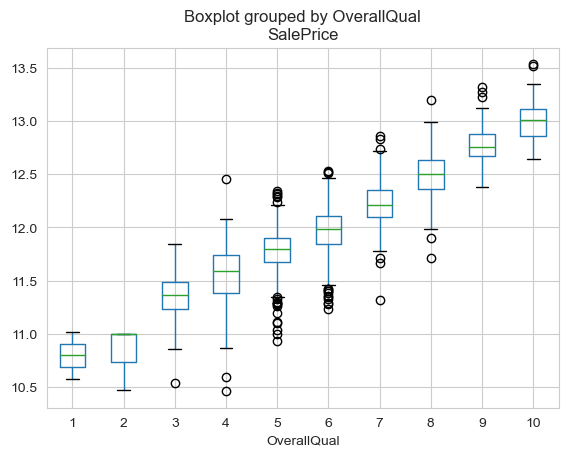

In [77]:
plt.figure(figsize = ((15, 10)))
df.boxplot(by = 'OverallQual', column = 'SalePrice')
plt.show()

As the quality increases, price of the houses also increase

### Exploring Categorical Variables

In [80]:
def horizontal_plot(data, column_name, color, plot_title):
    
    """
    A function that plots a horizontal bar graph for the given column name
    """
    
    fig, ax = plt.subplots(figsize = (9, 6))
    
    # below code gives no. of categories in each column of a df in the assending order
    title_cnt = data[column_name].value_counts().sort_values(ascending = False).reset_index()

    mn = ax.barh(title_cnt.iloc[:, 0], title_cnt.iloc[:, 1], edgecolor = 'black', color =
                sns.color_palette(color, len(title_cnt)))

    for s in ['top','bottom','left','right']:
        ax.spines[s].set_visible(False)

    # Remove x,y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad=5)
    ax.yaxis.set_tick_params(pad=10)

    # Add x,y gridlines
    ax.grid(True)
    ax.grid(color='grey', linestyle='-.', linewidth=1, alpha=0.2)
    #ax.grid(b=True, color='grey', linestyle='-.', linewidth=1, alpha=0.2)

    # Show top values 

    ax.set_title(plot_title,weight='bold',loc='center', pad=10, fontsize=16)
    
    ax.set_xlabel('Count', weight='bold')

    # this code is used to write the label values on the bar plot.
    for i in ax.patches:
        ax.text(i.get_width() + 1.0, i.get_y() + 0.5, str(round((i.get_width()), 2)),
                fontsize=10, fontweight='bold', color='grey')

    plt.yticks(weight='bold')
    plt.xticks(weight='bold')

    plt.show()

In [81]:
df.shape

(1458, 80)

In [82]:
asd=df['Neighborhood'].value_counts().sort_values(ascending = False).reset_index()
asd.shape

(25, 2)

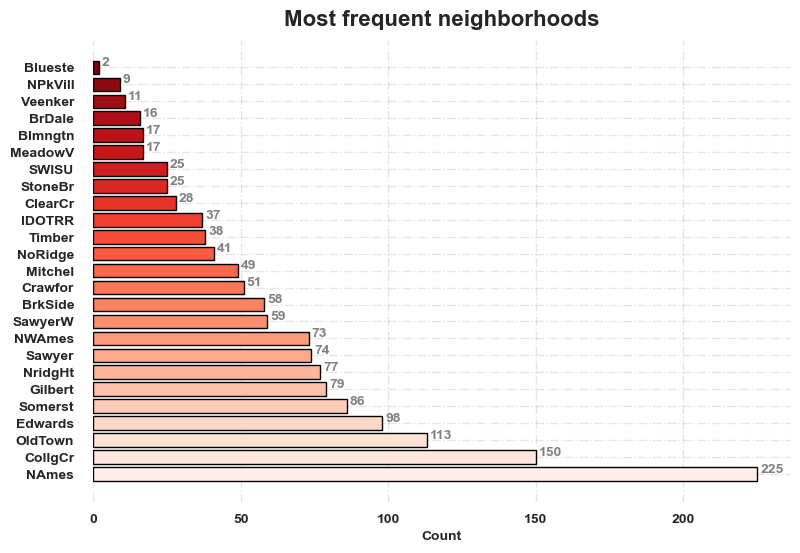

In [83]:
horizontal_plot(df, 'Neighborhood', 'Reds', 'Most frequent neighborhoods')

Most of the houses are present in the locations of : Names, Collg Cr, OldTown, Edwards and Somerst

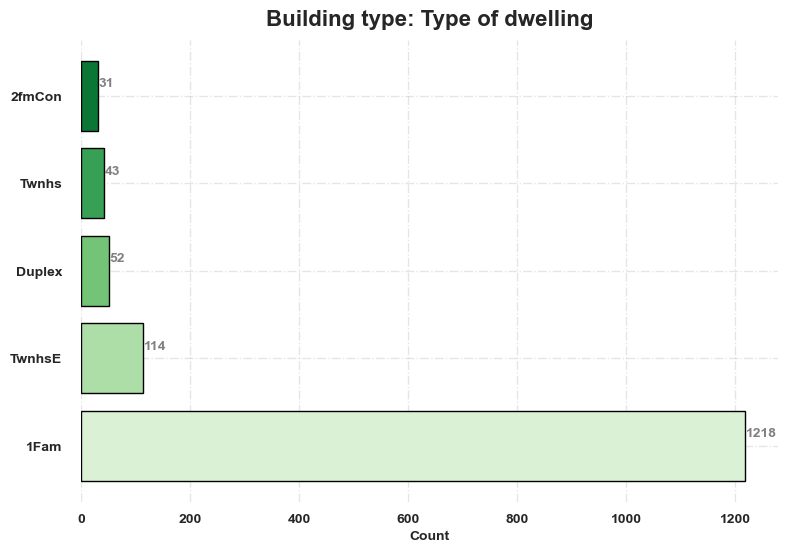

In [85]:
horizontal_plot(df, 'BldgType', 'Greens', 'Building type: Type of dwelling')

Most of the houses are a Single-family Detached (1Fam)

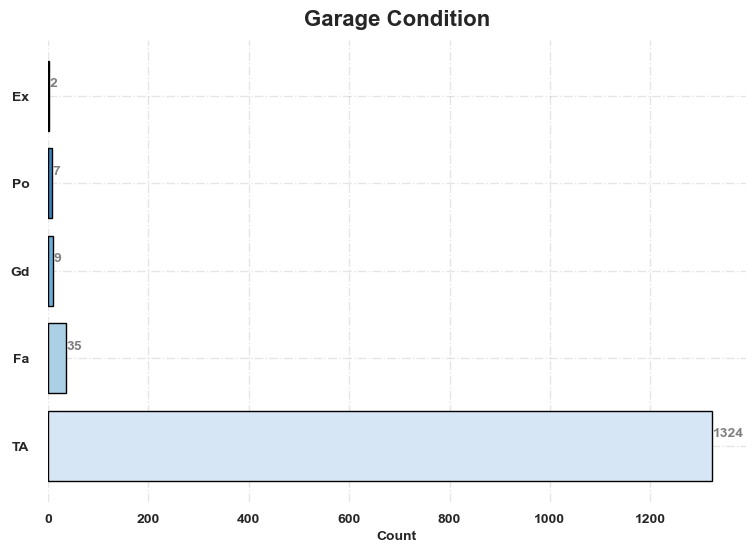

In [87]:
horizontal_plot(df, 'GarageCond', 'Blues', 'Garage Condition')

Most of the houses have Typically Average Garage Condition. Only couple of houses have Excellent Garage Condition.

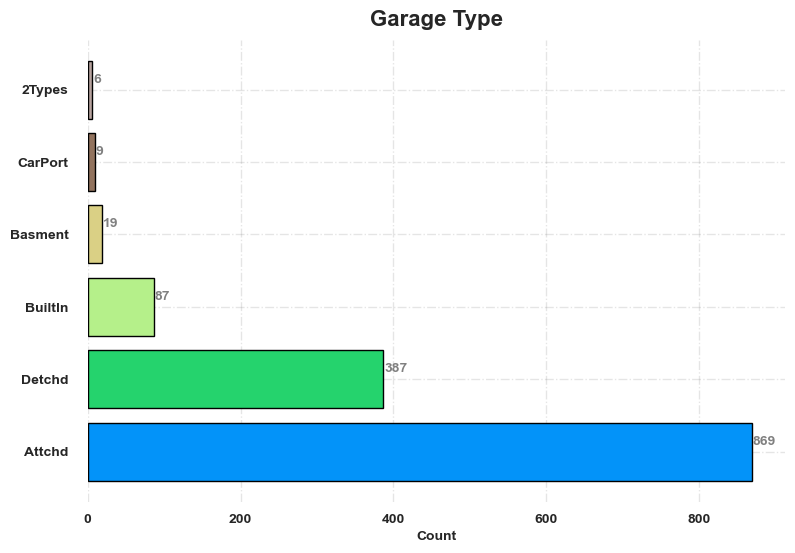

In [89]:
horizontal_plot(df, 'GarageType', 'terrain', 'Garage Type')

Most of the houses have Attached Garages and only 19 have Garages in the Basement.

## 3. Feature Engineering

First let's combine the train and test features.

In [93]:
df.shape

(1458, 80)

In [94]:
y = df['SalePrice'].reset_index(drop = True)
train_features = df.drop('SalePrice', axis = 1)
test_features = test.copy()

features = pd.concat((train_features, test_features)).reset_index(drop = True)

In [95]:
features.shape

(2917, 79)

Some of the variables given in the description should be of string data type but instead they are stored as numerical data type. First let's change them into string data type

In [97]:
(features['MoSold']).info()

<class 'pandas.core.series.Series'>
RangeIndex: 2917 entries, 0 to 2916
Series name: MoSold
Non-Null Count  Dtype
--------------  -----
2917 non-null   int64
dtypes: int64(1)
memory usage: 22.9 KB


In [98]:
(features['MSSubClass']).info()

<class 'pandas.core.series.Series'>
RangeIndex: 2917 entries, 0 to 2916
Series name: MSSubClass
Non-Null Count  Dtype
--------------  -----
2917 non-null   int64
dtypes: int64(1)
memory usage: 22.9 KB


In [99]:
(features['YrSold']).info()

<class 'pandas.core.series.Series'>
RangeIndex: 2917 entries, 0 to 2916
Series name: YrSold
Non-Null Count  Dtype
--------------  -----
2917 non-null   int64
dtypes: int64(1)
memory usage: 22.9 KB


In [100]:
#features['MSSubClass'] = features['MSSubClass'].apply(str)
#features['MoSold'] = features['MoSold'].astype(str)
#features['YrSold'] = features['YrSold'].astype(str)

We have already normalized the target variable in the above section. Let's plot it again

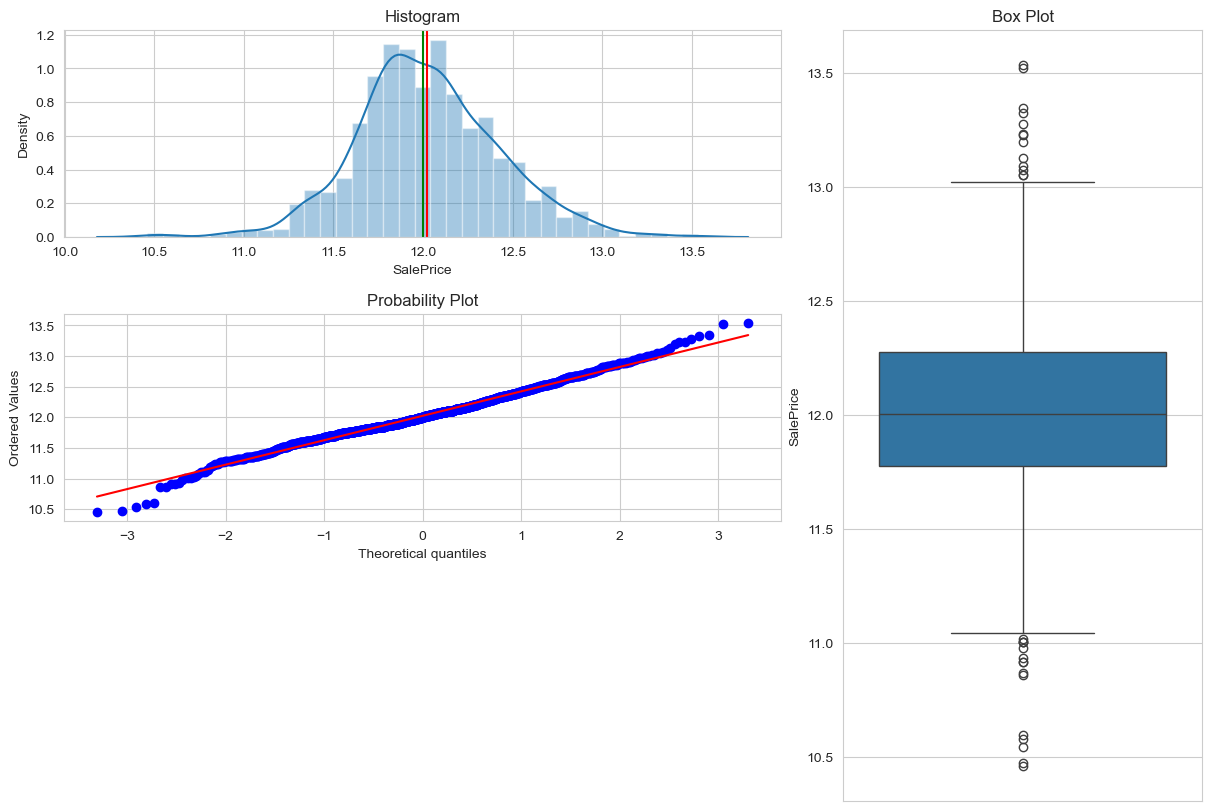

In [102]:
three_chart_plot(df, 'SalePrice')

Let' see the null values statistics of the combined dataset.

In [104]:
null_table(features).sort_values(by = 'Approximate Percentage of Null Values').tail(35)

,Columns,Count of Null Values,Approximate Percentage of Null Values
16,OverallQual,0,0.000000
60,GarageCars,1,0.034282
61,GarageArea,1,0.034282
52,KitchenQual,1,0.034282
33,BsmtFinSF1,1,0.034282
41,Electrical,1,0.034282
77,SaleType,1,0.034282
22,Exterior1st,1,0.034282
35,BsmtFinSF2,1,0.034282
37,TotalBsmtSF,1,0.034282


We can see that there are 4 features having more than 80% missing values. We will drop these 4 features.

In [106]:
features = features.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence','MasVnrType','FireplaceQu'], axis = 1)
features.shape

(2917, 73)

In [107]:
null_table(features).sort_values(by = 'Approximate Percentage of Null Values').tail(35)

,Columns,Count of Null Values,Approximate Percentage of Null Values
15,OverallQual,0,0.000000
16,OverallCond,0,0.000000
17,YearBuilt,0,0.000000
18,YearRemodAdd,0,0.000000
72,SaleCondition,0,0.000000
20,RoofMatl,0,0.000000
19,RoofStyle,0,0.000000
31,BsmtFinSF1,1,0.034282
33,BsmtFinSF2,1,0.034282
58,GarageArea,1,0.034282


Now none of the features have above 80% missing values.

We must observe here that **NA has a different meaning**. Here we can not impute or remove those rows having NA. For example if one of the values for Alley is NA, it means that home has no Alley or if the value of GarageType is NA it means that particular home has no Garage. That's why wee need to take into account these values as it can affect the final prices of the house.

I have identified some of the features which have NA as a category, they are listed in form of a list below. We will replace these null values with None.

Reading through the description of the features is very important, otherwise the above points can't be concluded.

In [111]:
#description = open("data_description.txt", "r")
#print(description.read())

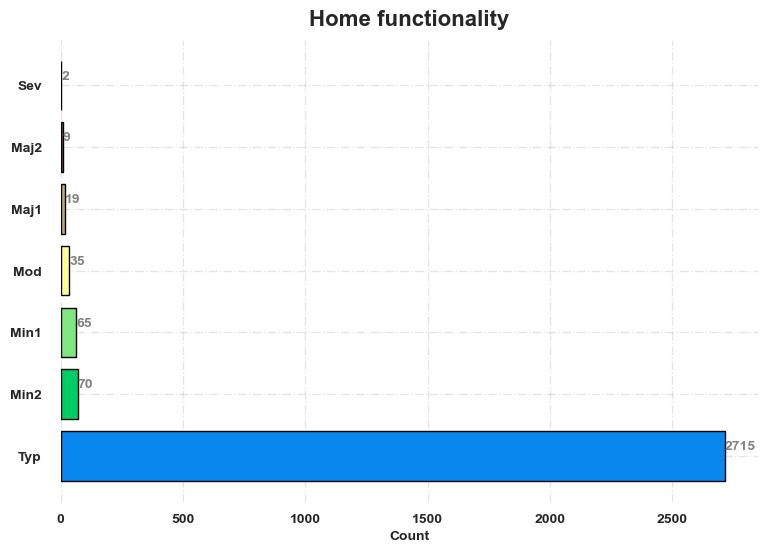

In [112]:
horizontal_plot(features, 'Functional', 'terrain', 'Home functionality')

In [113]:
features['Functional'].mode()

0    Typ
Name: Functional, dtype: object

In [114]:
def filling_null(features):
    
    # In the description for 'Functional Feature', it is given that Typ refers to the Typical Functionality
    # We will replace null values in the 'Functional' feature with 'Typ'
    
    features['Functional'] = features['Functional'].fillna('Typ')
    
    # Replace the null values in the below columns with their mode. We are replacing with mode because
    # all of these features are categorical variable, we can't take the mean nor the median.
    
    features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])
    
    features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])
    
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])

    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    
    # In order to fill the null values for MSZoing, we will take into account the MSSubClass featue.
    # We are doing so because the type of dwelling in a given area largely affects the zone of the area.
    
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # In order to fill the null values for LotFrontage(Linear feet of street connected to property) 
    # we will fill it with median of the values grouped by Neighborhood.
    
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    
    # As mentioned before that the 'NA' value in many columns represent the absence of that feature for
    # a particular house, we will replace those null values with None.
    # 'None' for categorical feature and 0 for numerical feature.
    
    cat_features = features.select_dtypes(include = 'object').columns
    num_features = features.select_dtypes(exclude = 'object').columns
    
    features[cat_features] = features[cat_features].fillna('None')
    features[num_features] = features[num_features].fillna(0)
        
    return features

In [115]:
features = filling_null(features)
features.shape

(2917, 73)

In [116]:
features.isnull().sum().sum()

0

Now there are 0 null values in the given dataset

Now let's create some new features. 

### Feature Creation

In [120]:
def new_features(features):
    
    features['HasPool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    features['Has2ndFloor'] = features['2ndFlrSF'].apply(lambda x : 1 if x > 0 else 0)
    features['HasGarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    features['HasBsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    features['HasFireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    # Adding total sqfootage features 
    # In order to get the total area of the house we have to add the basement area, 1st floor area and 2nd floor area.
    
    features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
    
    # Total number of bathrooms = number of full bathrooms + 0.5 * number of half bathrooms
    # + number of bathrooms in basement + 0.5 * number of half bathrooms in the basement.
    
    features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                                   features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))
    
    features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                                  features['EnclosedPorch'] + features['ScreenPorch'])

    # Add years since remodel
    features['YearsSinceRemodel'] = features['YrSold'].astype(int) - features['YearRemodAdd'].astype(int)

    return features

We have added certain features which are quite intuitive and are taken into consideration in real life too while buying the house. Like what's the total area in square feet of the house or how many bathrooms are there in the house. We could also look for the availability of swimming pool, garage, fireplace and basement in the house. That's why I have added such features in the dataset.

In [122]:
features = new_features(features)
features.shape

(2917, 82)

Let's analyse the skewness of the numerical features.

In [124]:
num_features = features.select_dtypes(exclude = 'object').columns

skewed_features = features[num_features].apply(lambda x : x.skew()).sort_values(ascending = False)
skew_features = pd.DataFrame({'Skew Value' : skewed_features})

skew_features.head(10)

,Skew Value
MiscVal,21.950962
PoolArea,17.697766
HasPool,15.502729
LotArea,13.116240
LowQualFinSF,12.090757
3SsnPorch,11.377932
KitchenAbvGr,4.302763
BsmtFinSF2,4.146636
EnclosedPorch,4.004404
ScreenPorch,3.947131


There's is quite a lot of asymmetry in the above features. We will need to fix the skewness

In [126]:
def fix_skew(features):
    
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    
    ## Getting all the data that are not of "object" type. 
    numerical_columns = features.select_dtypes(exclude = 'object').columns

    # Check the skew of all numerical features
    skewed_features = features[numerical_columns].apply(lambda x: x.skew()).sort_values(ascending=False)
    
    high_skew = skewed_features[abs(skewed_features) > 0.5]
    skewed_features = high_skew.index

    # Perform the Box-Cox transformation (normailization and apply log to the features)
    for column in skewed_features:
        features[column] = boxcox1p(features[column], boxcox_normmax(features[column] + 1))
        
    return features

In [127]:
features = fix_skew(features)
features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SaleCondition,HasPool,Has2ndFloor,HasGarage,HasBsmt,HasFireplace,TotalSF,Total_Bathrooms,Total_porch_sf,YearsSinceRemodel
0,6.499670,RL,18.144577,13.833056,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,Normal,0.0,1,0.840362,18.316972,0,35.576144,3.5,12.339283,5
1,4.249692,RL,20.673630,14.117920,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,Normal,0.0,0,0.840362,18.316972,1,35.371879,2.5,0.000000,31
2,6.499670,RL,18.668051,14.476515,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,Normal,0.0,1,0.840362,18.316972,1,36.241063,3.5,10.090749,6
3,6.862537,RL,17.249654,14.106199,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,Abnorml,0.0,1,0.840362,18.316972,1,35.120715,2.0,28.165644,36
4,6.499670,RL,21.314287,15.022010,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,Normal,0.0,1,0.840362,18.316972,1,39.002308,3.5,14.606323,8


In [128]:
#features = fix_skew(features)
#features.head()

In [129]:
features = pd.get_dummies(features).reset_index(drop=True)
features.shape

(2917, 284)

In [130]:
X = features.iloc[:len(y), :]
test = features.iloc[len(y):, :]

In [131]:
X.shape, test.shape, y.shape

((1458, 284), (1459, 284), (1458,))

## 4. Training and Testing Machine Learning Models

In [133]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [134]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [135]:
from sklearn.metrics import r2_score

In [136]:
def evaluation(model, x_train_std, y_train, x_test, y_test, train = True):
    if train == True:
        pred = model.predict(x_train_std)
        
        print("Train Result:\n================================================")
        print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train, pred))}")
        print("_______________________________________________")
        print(f"Mean Squared Error: {mean_squared_error(y_train, pred)}")
        print("_______________________________________________")
        print(f"Mean Absolute Error: \n{mean_absolute_error(y_train, pred)}")
        print("_______________________________________________")
        print(f"R2 score: \n{r2_score(y_train, pred)}")
        print("_______________________________________________")
    print()
    
    if train == False:
        pred = model.predict(x_test)
        
        print("Test Result:\n================================================")
        print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, pred))}")
        print("_______________________________________________")
        print(f"Mean Squared Error: {mean_squared_error(y_test, pred)}")
        print("_______________________________________________")
        print(f"Mean Absolute Error: \n{mean_absolute_error(y_test, pred)}")
        print("_______________________________________________")
        print(f"R2 score: \n{r2_score(y_test, pred)}")
        print("_______________________________________________")

### Lasso Regression

In [138]:
from sklearn.linear_model import Lasso
ls = Lasso(alpha = 0.1)
ls.fit(X_train, y_train)

evaluation(ls, X_train, y_train, X_test, y_test, True) # Training
evaluation(ls, X_train, y_train, X_test, y_test, False) # Testing

Train Result:
Root Mean Squared Error: 0.1700404335638932
_______________________________________________
Mean Squared Error: 0.028913749046596778
_______________________________________________
Mean Absolute Error: 
0.1215182100862265
_______________________________________________
R2 score: 
0.8163342675739205
_______________________________________________


Test Result:
Root Mean Squared Error: 0.18742449272920922
_______________________________________________
Mean Squared Error: 0.0351279404748014
_______________________________________________
Mean Absolute Error: 
0.12649427886465178
_______________________________________________
R2 score: 
0.7916198896385563
_______________________________________________


In [139]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

# Example of tuning alpha
lasso = Lasso()
param_grid = {'alpha': [0.0001,0.0005,0.001, 0.0025, 0.005, 0.01]}
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
print("Optimal alpha:", best_alpha)

Optimal alpha: 0.0005


In [156]:
ls = Lasso(alpha = 0.0005)
ls.fit(X_train, y_train)
evaluation(ls, X_train, y_train, X_test, y_test, True) # Training
evaluation(ls, X_train, y_train, X_test, y_test, False) # Testing

Train Result:
Root Mean Squared Error: 0.0970652635222172
_______________________________________________
Mean Squared Error: 0.009421665382637468
_______________________________________________
Mean Absolute Error: 
0.06750910042882723
_______________________________________________
R2 score: 
0.9401517572008108
_______________________________________________


Test Result:
Root Mean Squared Error: 0.10732836553331364
_______________________________________________
Mean Squared Error: 0.011519378048052588
_______________________________________________
Mean Absolute Error: 
0.07436667904799275
_______________________________________________
R2 score: 
0.9316666665764167
_______________________________________________


By proper selectoin of alpha value, the R2 score of Laso model has been improved from 0.8 to 0.94. 

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Ridge Regression

In [173]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha = 0.01)
ridge.fit(X_train, y_train)

evaluation(ridge, X_train, y_train, X_test, y_test, True)
evaluation(ridge, X_train, y_train, X_test, y_test, False)

Train Result:
Root Mean Squared Error: 0.08854647957249942
_______________________________________________
Mean Squared Error: 0.007840479044683057
_______________________________________________
Mean Absolute Error: 
0.06091147365552596
_______________________________________________
R2 score: 
0.9500912091080534
_______________________________________________


Test Result:
Root Mean Squared Error: 0.10684506637552747
_______________________________________________
Mean Squared Error: 0.011415868208790873
_______________________________________________
Mean Absolute Error: 
0.07752835137681001
_______________________________________________
R2 score: 
0.9326387878130361
_______________________________________________


In [181]:
param_grid = {'alpha': [5,10,20,50,100]}
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
print("Optimal alpha:", best_alpha)

Optimal alpha: 10


In [183]:
ridge = Ridge(alpha = 10)
ridge.fit(X_train, y_train)
ridge.fit(X_train, y_train)
evaluation(ridge, X_train, y_train, X_test, y_test, True)
evaluation(ridge, X_train, y_train, X_test, y_test, False)

Train Result:
Root Mean Squared Error: 0.09473696047523578
_______________________________________________
Mean Squared Error: 0.008975091680086386
_______________________________________________
Mean Absolute Error: 
0.064319591095072
_______________________________________________
R2 score: 
0.9428688003188729
_______________________________________________


Test Result:
Root Mean Squared Error: 0.1013569074968141
_______________________________________________
Mean Squared Error: 0.010273222697317732
_______________________________________________
Mean Absolute Error: 
0.07276383364671436
_______________________________________________
R2 score: 
0.9393811560101
_______________________________________________


By increasing alpha value from 0.1 to 100, the best values found is: 10 but modoel didn't increase the R2 score value

### ElasticNet Regressor

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [232]:
from sklearn.linear_model import ElasticNet
esn = ElasticNet(alpha=0.1)


In [234]:
esn.fit(X_train, y_train)

evaluation(esn, X_train, y_train, X_test, y_test, True)
evaluation(esn, X_train, y_train, X_test, y_test, False)

Train Result:
Root Mean Squared Error: 0.15400004538011286
_______________________________________________
Mean Squared Error: 0.02371601397707682
_______________________________________________
Mean Absolute Error: 
0.10843081696999357
_______________________________________________
R2 score: 
0.8493512871572895
_______________________________________________


Test Result:
Root Mean Squared Error: 0.16960184800090314
_______________________________________________
Mean Squared Error: 0.028764786845321456
_______________________________________________
Mean Absolute Error: 
0.1140252967686918
_______________________________________________
R2 score: 
0.8293663284458359
_______________________________________________


In [236]:
param_grid = {'alpha': [0.0005,0.001,0.0025,0.01,0.05,0.1]}
grid_search = GridSearchCV(esn, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
print("Optimal alpha:", best_alpha)

Optimal alpha: 0.001


In [237]:
esn = ElasticNet(alpha=0.001)
esn.fit(X_train, y_train)
esn.fit(X_train, y_train)
evaluation(esn, X_train, y_train, X_test, y_test, True)
evaluation(esn, X_train, y_train, X_test, y_test, False)

Train Result:
Root Mean Squared Error: 0.09733797105793421
_______________________________________________
Mean Squared Error: 0.009474680609675237
_______________________________________________
Mean Absolute Error: 
0.06765375759301172
_______________________________________________
R2 score: 
0.9398149942134882
_______________________________________________


Test Result:
Root Mean Squared Error: 0.10785849657924404
_______________________________________________
Mean Squared Error: 0.0116334552843348
_______________________________________________
Mean Absolute Error: 
0.07445648714863037
_______________________________________________
R2 score: 
0.9309899566194733
_______________________________________________


By decreasing alpha value from 0.1 to 0.0005, the best values found is: 0.001 and the model increase the R2 score value from 0.84 to 0.94. 

### XGB Regressor

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [265]:
from xgboost import XGBClassifier

In [315]:
from sklearn.preprocessing import StandardScaler
model = XGBClassifier(subsample=0.6)
scaler = StandardScaler()
x_trainScaled = scaler.fit_transform(X_train)
x_testScaled = scaler.transform(X_test)

In [317]:
import xgboost as xgb
xgb_regress = xgb.XGBRegressor(n_estimators = 400, learning_rate = 0.05)
xgb_regress.fit(x_trainScaled, y_train)

evaluation(xgb_regress, x_trainScaled, y_train, x_testScaled, y_test, True)
evaluation(xgb_regress, x_trainScaled, y_train, x_testScaled, y_test, False)

Train Result:
Root Mean Squared Error: 0.014126970958359932
_______________________________________________
Mean Squared Error: 0.00019957130845834494
_______________________________________________
Mean Absolute Error: 
0.009991157300702453
_______________________________________________
R2 score: 
0.9987296231971139
_______________________________________________


Test Result:
Root Mean Squared Error: 0.11634607607621147
_______________________________________________
Mean Squared Error: 0.013536409418331589
_______________________________________________
Mean Absolute Error: 
0.08654585439796922
_______________________________________________
R2 score: 
0.9201261848506896
_______________________________________________


Traing R2 is higher than testing R2 value, so the model is a overfitting one. 
So need to do hyper-parameter tuning

In [375]:
xgb_regress = xgb.XGBRegressor(subsample=0.8, max_depth=2, min_child_weight=5, n_estimators = 500, learning_rate = 0.05)
xgb_regress.fit(x_trainScaled, y_train)

evaluation(xgb_regress, x_trainScaled, y_train, x_testScaled, y_test, True)
evaluation(xgb_regress, x_trainScaled, y_train, x_testScaled, y_test, False)

Train Result:
Root Mean Squared Error: 0.08007701924385079
_______________________________________________
Mean Squared Error: 0.006412329010980048
_______________________________________________
Mean Absolute Error: 
0.055165498445830234
_______________________________________________
R2 score: 
0.9591821385000204
_______________________________________________


Test Result:
Root Mean Squared Error: 0.10393457195786727
_______________________________________________
Mean Squared Error: 0.01080239524806509
_______________________________________________
Mean Absolute Error: 
0.0780174506523836
_______________________________________________
R2 score: 
0.9362586861442548
_______________________________________________


In [ ]:
Traing R2 is almost equal to testing R2 value, so the model is working as a best fit one. 

### Conclusions:
1. Laso Regression model: is a behaving differently model
2. Ridge Regression model: is the bestfit model
3. XGB Regression model: is a underfit model
4. Laso and Ridge models showed less accuracy after converting all numerical features into a Standard scaler use as input
2. Laso and Ridge models showed higher accuracy with the with the X_train data directly
3. XGBboost models didn't work with the X_train data directly whereas with standardschlar data worked well.

## Hyper parameters tuning

1. Change the random state: 0 to 42 (laso and ride models)
2. use grid search: change different alpha values
3. ElasticNet Regressor
4. Improved the XGB performance